In [98]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Input,RNN,SimpleRNN,LSTM, GRU,TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
import string

import nltk
# nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from IPython.display import Image
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score,ConfusionMatrixDisplay
import re
import matplotlib.pyplot as plt

In [58]:
import pandas as pd
import numpy as np 

df = pd.read_csv('bbc-news-data.csv',sep="\t")

In [59]:
df.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [60]:
df.shape

(2225, 4)

In [61]:
df.isna().sum()

category    0
filename    0
title       0
content     0
dtype: int64

<Axes: xlabel='count', ylabel='category'>

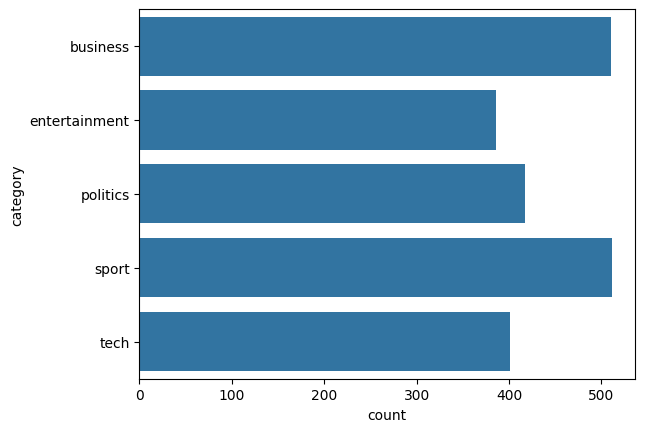

In [62]:
sns.countplot(df['category'])

In [63]:
stop_words.extend(string.punctuation)

In [64]:
from nltk.tokenize import word_tokenize

In [65]:
title = df['title']
title[1000]
word_tokenize(title[1000])

['Muslim', 'police', 'stops', "'more", 'likely', "'"]

In [66]:
def get_clean_data(sent):
    words = sent.lower()
    words = words.replace(".",". ")
    word_tokenizer = word_tokenize(words)
    words = [word for word in word_tokenizer if word not in stop_words]
    tokens = [tok.translate(str.maketrans(' ', ' ', string.punctuation)) for tok in words]
    words = " ".join(words)
    words = words.strip()
    return words

In [67]:
title_cleaned = df['title'].apply(get_clean_data)

In [68]:
title[1000]

"Muslim police stops 'more likely'"

In [69]:
title_cleaned[1000]

"muslim police stops 'more likely"

In [70]:
title_cleaned

0        ad sales boost time warner profit
1            dollar gains greenspan speech
2        yukos unit buyer faces loan claim
3       high fuel prices hit ba 's profits
4        pernod takeover talk lifts domecq
                       ...                
2220         bt program beat dialler scams
2221       spam e-mails tempt net shoppers
2222                          careful code
2223       us cyber security chief resigns
2224                  losing online gaming
Name: title, Length: 2225, dtype: object

<Axes: ylabel='title'>

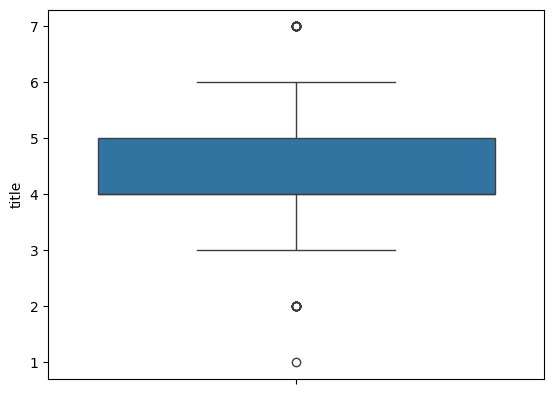

In [71]:
sns.boxplot(title_cleaned.str.split(" ").str.len())

In [72]:
print("Max length : ", title_cleaned.str.split(" ").str.len().max())

Max length :  7


In [73]:
max_len = title_cleaned.str.split(" ").str.len().max()

In [74]:
xtrain,xtest,ytrain,ytest = train_test_split(title_cleaned,df['category'],test_size=0.2,random_state=5)

In [75]:
xtrain.shape, ytrain.shape, xtest.shape

((1780,), (1780,), (445,))

In [76]:
ytrain = pd.get_dummies(ytrain).values
ytest = pd.get_dummies(ytest).values

In [89]:
n_class = len(set(df['category']))
n_class

5

In [77]:
def tokenize_and_pad(inp_text, max_len,tok):
    text_seq = tok.texts_to_sequences(inp_text)
    text_seq = pad_sequences(text_seq,maxlen=max_len,padding='post')
    return text_seq
text_tokenizer = Tokenizer()
text_tokenizer.fit_on_texts(xtrain)

xtrain = tokenize_and_pad(inp_text=xtrain, max_len=max_len,tok=text_tokenizer)
xtest = tokenize_and_pad(inp_text=xtest, max_len=max_len,tok=text_tokenizer)

vocab_size = len(text_tokenizer.word_index)+1
vocab_size

3359

In [92]:
print("xtrain shape",xtrain.shape)
print("xtest shape",xtest.shape)

xtrain shape (1780, 7)
xtest shape (445, 7)


# Latent Dimension

In [82]:
latent_dim=50
embedding_dim=100

In [83]:
from tensorflow.keras.models import Sequential

In [90]:
model = Sequential([

    Embedding(input_dim=vocab_size,output_dim=embedding_dim,trainable=True),
    SimpleRNN(latent_dim,recurrent_dropout=0.2,return_sequences=True),
    SimpleRNN(latent_dim,recurrent_dropout=0.2,return_sequences=False),
    Dense(n_class,activation='softmax')
])


In [91]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         335900    
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 50)          7550      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dense (Dense)               (None, 5)                 255       
                                                                 
Total params: 348,755
Trainable params: 348,755
Non-trainable params: 0
_________________________________________________________________


In [94]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])

early_stopping = EarlyStopping(monitor='val_acc',
                               mode='max',
                               verbose=1,
                               patience=5)

model.fit(x=xtrain, y=ytrain,
          validation_data=(xtest, ytest),
          batch_size=64,
          epochs=10,
          callbacks=[early_stopping])

Epoch 1/10
28/28 [==============================] - 7s 50ms/step - loss: 1.5737 - acc: 0.2764 - val_loss: 1.4920 - val_acc: 0.3865
Epoch 2/10
28/28 [==============================] - 1s 31ms/step - loss: 1.1194 - acc: 0.6028 - val_loss: 1.0863 - val_acc: 0.6000
Epoch 3/10
28/28 [==============================] - 1s 31ms/step - loss: 0.4504 - acc: 0.8848 - val_loss: 0.9575 - val_acc: 0.6899
Epoch 4/10
28/28 [==============================] - 1s 30ms/step - loss: 0.1430 - acc: 0.9775 - val_loss: 1.0457 - val_acc: 0.7124
Epoch 5/10
28/28 [==============================] - 1s 33ms/step - loss: 0.0624 - acc: 0.9916 - val_loss: 1.1467 - val_acc: 0.7124
Epoch 6/10
28/28 [==============================] - 1s 32ms/step - loss: 0.0413 - acc: 0.9944 - val_loss: 1.2402 - val_acc: 0.7101
Epoch 7/10
28/28 [==============================] - 1s 31ms/step - loss: 0.0278 - acc: 0.9972 - val_loss: 1.2629 - val_acc: 0.7281
Epoch 8/10
28/28 [==============================] - 1s 32ms/step - loss: 0.0194 - a

In [96]:
prediction = model.predict(xtest)
prediction = prediction.argmax(axis=1)
validation = ytest.argmax(axis=1)
print(f"Accuracy: {accuracy_score(prediction, validation)}")

14/14 [==============================] - 1s 6ms/step
Accuracy: 0.7325842696629213


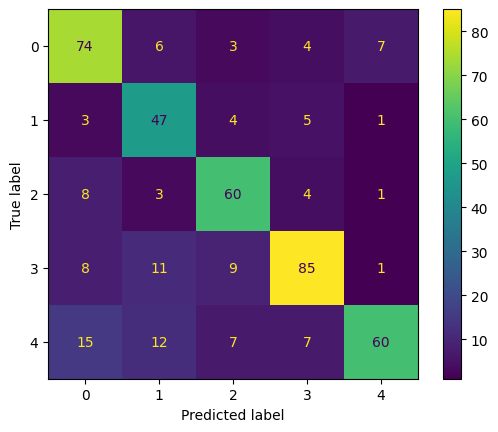

In [101]:
ConfusionMatrixDisplay(confusion_matrix(prediction, validation)).plot()

In [102]:
from sklearn.metrics import classification_report

In [103]:
print(classification_report(prediction, validation))

              precision    recall  f1-score   support

           0       0.69      0.79      0.73        94
           1       0.59      0.78      0.68        60
           2       0.72      0.79      0.75        76
           3       0.81      0.75      0.78       114
           4       0.86      0.59      0.70       101

    accuracy                           0.73       445
   macro avg       0.73      0.74      0.73       445
weighted avg       0.75      0.73      0.73       445

